# Segmentation

In [5]:
# import library

import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

(500, 892, 3)


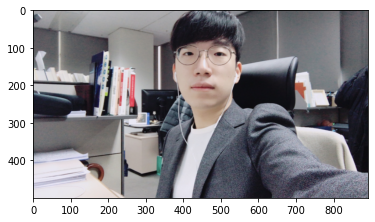

In [4]:
# image load
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

### 모델 다운로드

In [6]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 

model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7b0a1855c520>)

In [9]:
# 모델 생성

model = semantic_segmentation() # semantic segmentation 모델 클래스
model.load_pascalvoc_model(model_file) # pascal voc 데이터세 훈련 모델 로드

dict_keys(['class_ids', 'masks']) (500, 892, 3)


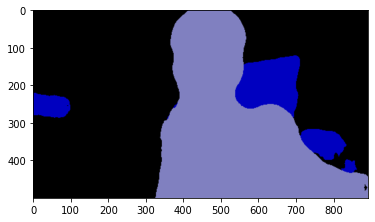

In [14]:
# 이미지 분할
segvalues, output = model.segmentAsPascalvoc(img_path)
print(segvalues.keys(), output.shape)

# 이미지 확인
plt.imshow(output)
plt.show()

In [13]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

In [15]:
# segmented value 확인
segvalues

{'class_ids': array([ 0,  9, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]])}

In [16]:
# 클래스 라벨 이름 출력
for class_id in segvalues["class_ids"]:
    print(LABEL_NAMES[class_id])

background
chair
person


In [21]:
#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

#생성한 20개의 컬러맵 출력
print(colormap[:20])

[[  0   0   0]
 [128   0   0]
 [  0 128   0]
 [128 128   0]
 [  0   0 128]
 [128   0 128]
 [  0 128 128]
 [128 128 128]
 [ 64   0   0]
 [192   0   0]
 [ 64 128   0]
 [192 128   0]
 [ 64   0 128]
 [192   0 128]
 [ 64 128 128]
 [192 128 128]
 [  0  64   0]
 [128  64   0]
 [  0 192   0]
 [128 192   0]]


In [22]:
# 사람을 나타내는 15번째 색상
colormap[15]

array([192, 128, 128])

In [23]:
seg_color = (128,128,192) # 색상순서 변경 RGB -> BGR

(500, 892)


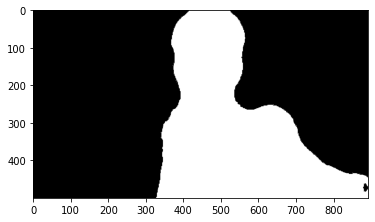

In [24]:
# 사람을 나타내는 컬러로 필터링(채널축)
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

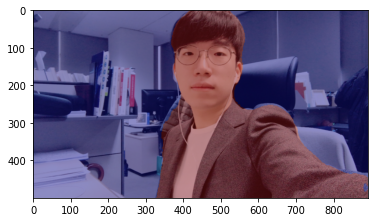

In [26]:
# 원래 이미지와 겹쳐서 확인

img_show = img_orig.copy()

img_mask = seg_map.astype(np.uint8) * 255

color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 배경 흐리게 하기

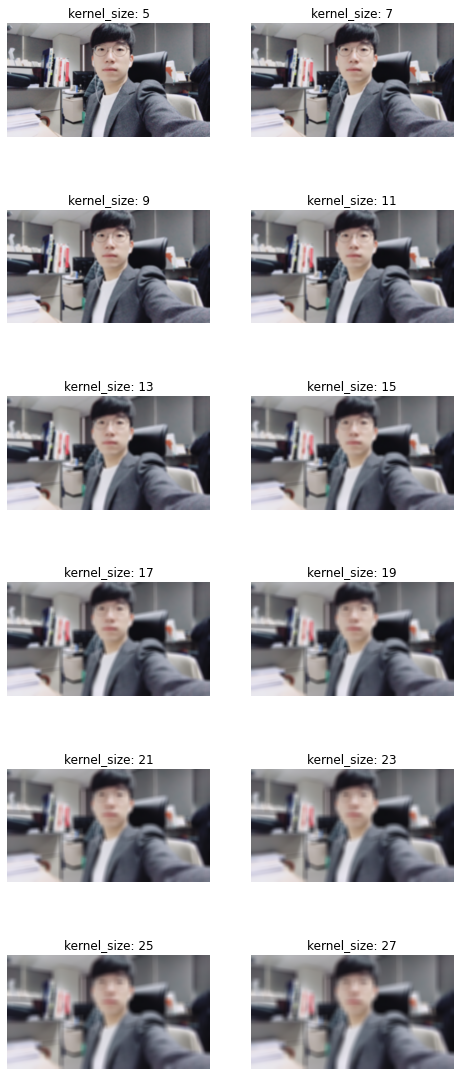

In [47]:
# blur 처리 테스트

fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(8, 20))
idx = 0
for kernel_size in range(5, 27+1, 2):
    row, col = idx//2, idx%2
    ax = axes[row][col]
    img_orig_blur = cv2.blur(img_orig, (kernel_size, kernel_size))
    ax.set_title(f"kernel_size: {kernel_size}")
    ax.axis("off")
    ax.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
    idx += 1
plt.show()

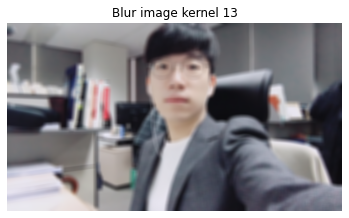

In [51]:
# kernel size 13
img_orig_blur = cv2.blur(img_orig, (13, 13))

plt.title(f"Blur image kernel 13")
plt.axis("off")
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

In [61]:
# blur 배경 추출

print("img_mask shape", img_mask.shape)
print("250, 450:", img_mask[250, 450])

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

print("img_mask_color shape", img_mask_color.shape)
print("250, 450:", img_mask_color[250, 450])

img_bg_mask = cv2.bitwise_not(img_mask_color)

print("img_bg_mask shape", img_bg_mask.shape)
print("250, 450:", img_bg_mask[250, 450])

img_mask shape (500, 892)
250, 450: 255
img_mask_color shape (500, 892, 3)
250, 450: [255 255 255]
img_bg_mask shape (500, 892, 3)
250, 450: [0 0 0]


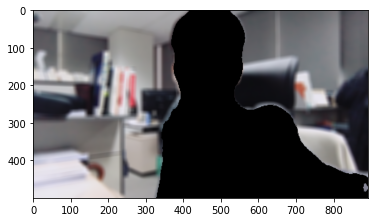

In [63]:
# 마스킹 된 블러 이미지
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 이미지 합성

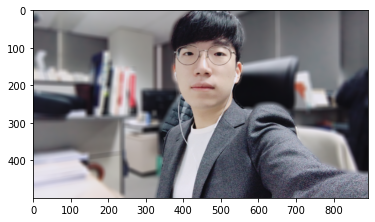

In [65]:
# 배경 블러 이미지 합성 시각화

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

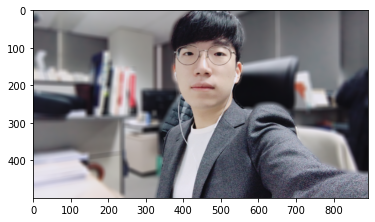

In [66]:
# img_orig_blur 사용해도 동일한 결과

img_concat = np.where(img_mask_color==255, img_orig, img_orig_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

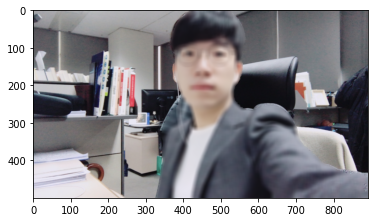

In [68]:
# 사람 부분을 블러처리

# 마스킹 이미지의 0인 부분으로 필터링, 필터에 걸리면 원본이미지, 아니면 블러이미지
img_person_blur = np.where(img_mask_color==0, img_orig, img_orig_blur)

plt.imshow(cv2.cvtColor(img_person_blur, cv2.COLOR_BGR2RGB))
plt.show()